In [1]:
from __future__ import print_function, division
import warnings
warnings.filterwarnings("ignore")
import os.path
import pandas as pd
import torch
import torch.nn as nn
from datasets import load_dataset
import cv2
from pathlib import Path
from sklearn.model_selection import train_test_split
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import dlib
import os
import argparse
import csv

In [9]:



def detect_face(image_paths,  SAVE_DETECTED_AT, default_max_size=800,size = 300, padding = 0.25):
    cnn_face_detector = dlib.cnn_face_detection_model_v1('dlib_models/mmod_human_face_detector.dat')
    sp = dlib.shape_predictor('dlib_models/shape_predictor_5_face_landmarks.dat')    #Please create a csv with one column 'img_path', contains the full paths of all images to be analyzed.
    #Also please change working directory to this file.edictor('dlib_models/shape_predictor_5_face_landmarks.dat')
    base = 2000  # largest width and height
    for index, image_path in enumerate(image_paths):
        if index % 1000 == 0:
            print('---%d/%d---' %(index, len(image_paths)))
        img = dlib.load_rgb_image(image_path)

        old_height, old_width, _ = img.shape

        if old_width > old_height:
            new_width, new_height = default_max_size, int(default_max_size * old_height / old_width)
        else:
            new_width, new_height =  int(default_max_size * old_width / old_height), default_max_size
        img = dlib.resize_image(img, rows=new_height, cols=new_width)

        dets = cnn_face_detector(img, 1)
        num_faces = len(dets)
        if num_faces == 0:
            print("Sorry, there were no faces found in '{}'".format(image_path))
            continue
        # Find the 5 face landmarks we need to do the alignment.
        faces = dlib.full_object_detections()
        for detection in dets:
            rect = detection.rect
            faces.append(sp(img, rect))
        images = dlib.get_face_chips(img, faces, size=size, padding = padding)
        for idx, image in enumerate(images):
            img_name = image_path.split("/")[-1]
            path_sp = img_name.split(".")
            face_name = os.path.join(SAVE_DETECTED_AT,  path_sp[0] + "_" + "face" + str(idx) + "." + path_sp[-1])
            dlib.save_image(image, face_name)

def predidct_age_gender_race(save_prediction_at, img_names):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model_fair_7 = torchvision.models.resnet34(pretrained=True)
    model_fair_7.fc = nn.Linear(model_fair_7.fc.in_features, 18)
    model_fair_7.load_state_dict(torch.load('dlib_models/res34_fair_align_multi_7_20190809.pt', map_location=torch.device('cpu')))
    model_fair_7 = model_fair_7.to(device)
    model_fair_7.eval()


    trans = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    # img pth of face images
    face_names = []
    # list within a list. Each sublist contains scores for all races. Take max for predicted race
    race_scores_fair = []
    gender_scores_fair = []
    age_scores_fair = []
    race_preds_fair = []
    gender_preds_fair = []
    age_preds_fair = []

    for index, img_name in enumerate(img_names):
        if index % 1000 == 0:
            print("Predicting... {}/{}".format(index, len(img_names)))

        face_names.append(img_name)
        image = img_name
        image = trans(image)
        image = image.view(1, 3, 224, 224)  # reshape image to match model dimensions (1 batch size)
        image = image.to(device)

        # fair
        outputs = model_fair_7(image)
        outputs = outputs.cpu().detach().numpy()
        outputs = np.squeeze(outputs)

        race_outputs = outputs[:7]
        gender_outputs = outputs[7:9]
        age_outputs = outputs[9:18]

        race_score = np.exp(race_outputs) / np.sum(np.exp(race_outputs))
        gender_score = np.exp(gender_outputs) / np.sum(np.exp(gender_outputs))
        age_score = np.exp(age_outputs) / np.sum(np.exp(age_outputs))

        race_pred = np.argmax(race_score)
        gender_pred = np.argmax(gender_score)
        age_pred = np.argmax(age_score)

        race_scores_fair.append(race_score)
        gender_scores_fair.append(gender_score)
        age_scores_fair.append(age_score)

        race_preds_fair.append(race_pred)
        gender_preds_fair.append(gender_pred)
        age_preds_fair.append(age_pred)



    result = pd.DataFrame([face_names,
                           race_preds_fair,
                           gender_preds_fair,
                           age_preds_fair,
                           race_scores_fair, 
                           gender_scores_fair,
                           age_scores_fair, ]).T
    result.columns = ['face_names',
                      'race_preds_fair',
                      'gender_preds_fair',
                      'age_preds_fair',
                      'race_scores_fair',
                      'gender_scores_fair',
                      'age_scores_fair']
    result.loc[result['race_preds_fair'] == 0, 'race'] = 'White'
    result.loc[result['race_preds_fair'] == 1, 'race'] = 'Black'
    result.loc[result['race_preds_fair'] == 2, 'race'] = 'Latino_Hispanic'
    result.loc[result['race_preds_fair'] == 3, 'race'] = 'East Asian'
    result.loc[result['race_preds_fair'] == 4, 'race'] = 'Southeast Asian'
    result.loc[result['race_preds_fair'] == 5, 'race'] = 'Indian'
    result.loc[result['race_preds_fair'] == 6, 'race'] = 'Middle Eastern'


    # gender
    result.loc[result['gender_preds_fair'] == 0, 'gender'] = 'Male'
    result.loc[result['gender_preds_fair'] == 1, 'gender'] = 'Female'

    # age
    result.loc[result['age_preds_fair'] == 0, 'age'] = '0-2'
    result.loc[result['age_preds_fair'] == 1, 'age'] = '3-9'
    result.loc[result['age_preds_fair'] == 2, 'age'] = '10-19'
    result.loc[result['age_preds_fair'] == 3, 'age'] = '20-29'
    result.loc[result['age_preds_fair'] == 4, 'age'] = '30-39'
    result.loc[result['age_preds_fair'] == 5, 'age'] = '40-49'
    result.loc[result['age_preds_fair'] == 6, 'age'] = '50-59'
    result.loc[result['age_preds_fair'] == 7, 'age'] = '60-69'
    result.loc[result['age_preds_fair'] == 8, 'age'] = '70+'

    result[['face_names',
            'race', 
            'gender', 'age',
            'race_scores_fair',
            'gender_scores_fair', 'age_scores_fair']].to_csv(save_prediction_at, index=False)

    print("saved results at ", save_prediction_at)


def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)



In [6]:
data_files = {"train": ["./Dataset/validation/data-00000-of-00001.arrow"]}
my_dataset = load_dataset("arrow", data_files=data_files, split="train")
df=my_dataset.to_pandas()
df.head()

Generating train split: 0 examples [00:00, ? examples/s]

,image,age,gender,race,service_test
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1,0,0,False
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,6,1,0,True
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4,0,3,True
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,1,5,True
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,0,6,False


In [7]:
x = []
y = []

for item in df["image"]:
    image_bytes = item['bytes']
    # Decodificar la imagen desde bytes
    image_array = np.frombuffer(image_bytes, dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    # Redimensionar la imagen a 48x48 píxeles
    image = cv2.resize(image, (96, 96))
    x.append(image)



In [10]:

# Ignorar argumentos no reconocidos
if __name__ == "__main__":

    # Asume que "predidct_age_gender_race" puede manejar una lista de rutas de imágenes
    # Si no es así, tendrás que modificar esta función o adaptarla para trabajar con una lista de rutas
    predidct_age_gender_race("test_outputs1.csv", x)

Predicting... 0/10954
Predicting... 1000/10954
Predicting... 2000/10954
Predicting... 3000/10954
Predicting... 4000/10954
Predicting... 5000/10954
Predicting... 6000/10954
Predicting... 7000/10954
Predicting... 8000/10954
Predicting... 9000/10954
Predicting... 10000/10954
saved results at  test_outputs1.csv


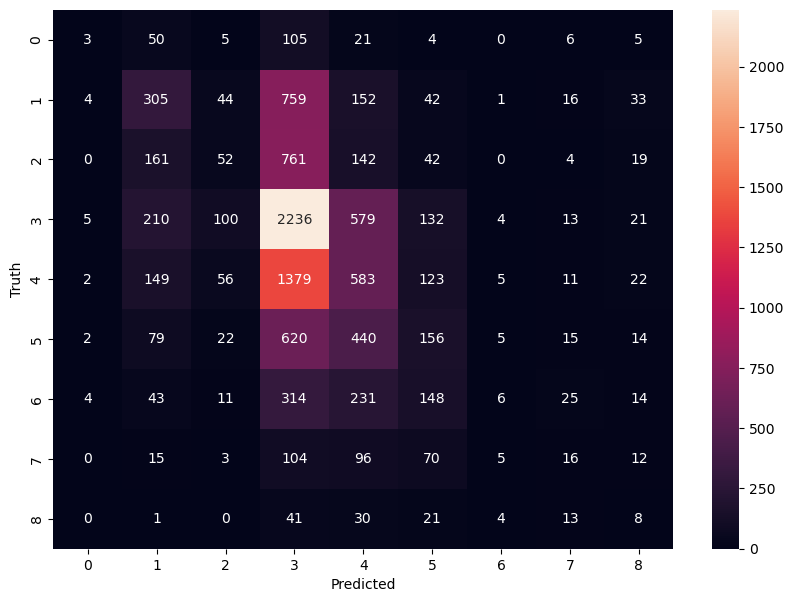

In [16]:
text = pd.read_csv("test_outputs1.csv")
from sklearn.metrics import plot_confusion_matrix
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
#y_test_age_str = [str(i) for i in y_test_age] 
cm=sklearn.metrics.confusion_matrix(df['age'], age)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [15]:
#set(y_test_age_str)
import csv 
import pandas as pd
text = pd.read_csv("test_outputs1.csv")

set(text["age"])
j=0
age=[]
for i in text["age"]:
    if i=='0-2':
        age.append(0)
    elif i=='3-9':
        age.append(1)
    elif i=='10-19':
        age.append(2)
    elif i=='20-29':
        age.append(3)    
    elif i=='30-39':
        age.append(4)
    elif i=='40-49':
        age.append(5)  
    elif i=='50-59':
        age.append(6)
    elif i=='60-69':
        age.append(7)
    elif i=='70+':
        age.append(8)
    else:
        print(i)
    j+=1


In [18]:
from sklearn.metrics import accuracy_score
precision = accuracy_score(df['age'], age)
print(f'La precisión de tu modelo es: {precision}')

La precisión de tu modelo es: 0.30719371918933724
